# Import all libraries

In [99]:
import numpy as np
import networkx as nx
from Architecture.Layers import Random_RNN
import matplotlib


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


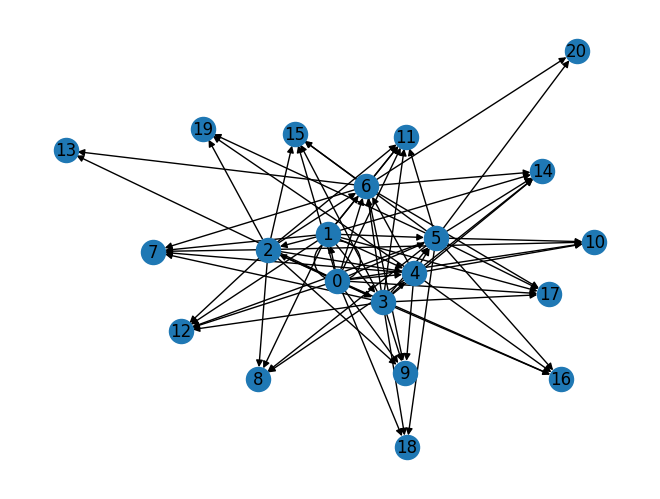

In [100]:
model = Random_RNN(in_features=7, neurons=7, out_features=7, connections=0.5)
nx.draw(model.graph, arrows=True, with_labels=True)
print(model.graph.nodes)

In [101]:
# Izhikeevich neuron


# Neuron parameters
V = 0
U = 0
a, b, c, d = [0.02, 1, 0, 2]
threshold = 700

# System parameters
work_time = 50
I = np.ones(work_time)



history = np.zeros((2, work_time))


for i in range(0, work_time):
    V = 0.04*V**2 + (5 * V) + 140 + I[i] - U
    U = a * (b * V - U)


    if V >= threshold:
        V = c
        U += d

    print(V)

    history[0][i] = V
    history[1][i] = U


plt.figure(figsize = (14,14))
plt.plot(history[1])

print(history[0])
pass

141.0
0
106.288
0
116.5707496448
0
113.72564649675117
0
114.52977824783648
0
114.303813736014
0
114.36741526069831
0
114.34952179961688
0
114.35455654627685
0
114.35313995352985
0
114.35353853478739
0
114.35342638783524
0
114.35345794212657
0
114.35344906383737
0
114.35345156188188
0
114.35345085901828
0
114.35345105677987
0
114.35345100113658
0
114.35345101679269
0
114.3534510123876
0
114.35345101362704
0
114.3534510132783
0
114.35345101337643
0
114.35345101334882
0
114.35345101335658
0


NameError: name 'plt' is not defined

In [ ]:
device = "cpu"

In [ ]:
# Create random individual 5*5
test_individ = torch.rand(5,5)

#### Get and visualize random individual

In [ ]:
img = test_individ.view((5, 5))
plt.imshow(img, cmap='Greys')
pass

# Testing SNN Model

In [ ]:
test_individ = torch.rand(5,5)
history = []

mnist_snn = MNIST_SNN(25, 5)
# optimizer = STDP(mnist_snn.parameters(), mnist_snn.spikes())

potentials_stack = torch.zeros(5)

with torch.no_grad():
    for j in range(0, 254):
            Y_pred = mnist_snn.forward(test_individ.view(-1, 5*5), j)
            history.append(Y_pred.clone())
            # optimizer.step()

            potentials_stack = torch.vstack((potentials_stack, mnist_snn.get_potentials()[1]))



# Show network parameters
# for p in MNIST_SNN.parameters(mnist_snn):
#     if p.requires_grad:
#         print(p.name, p.data.shape)
#
#         plt.figure(figsize = (14,14))
#         plt.imshow(p.data, cmap='Greys')


plt.figure(figsize = (14,14))
plt.plot(potentials_stack.T[0])
# plt.imshow(potentials_stack.T, aspect=10, cmap='Greys')

pass

# Load MNIST

In [ ]:
dataset = torchvision.datasets.MNIST(root = 'datasets', train = True, download = True, transform=torchvision.transforms.ToTensor())

#### Get and visualize random individual

In [ ]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]
plt.imshow(img, cmap='plasma')
plt.xlabel(f"NUMBER: {ans}")
pass

# Prepare and split data into train/test

In [ ]:
split_ratio = 0.00005
batch_size = 1
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

# print(dataset.shape)
print(dataset)

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

# Configure NN Model and hyper-parameters

In [ ]:
mnist_snn = MNIST_SNN(28*28, 10)
optimizer = STDP(mnist_snn.parameters(), mnist_snn.spike_history(), lr=0.002)
epochs = 1

# Train loop

In [ ]:
history = []
images = []

for name, param in mnist_snn.named_parameters():
    if param.requires_grad:
        # print (name, param.data.shape)
        plt.imshow(param.data[0].reshape((28, 28)), cmap='plasma')
        break

def train_mnist_SNN():
    with torch.no_grad():
        for epoch in range(0, epochs):
            for i, (features, ans) in enumerate(tqdm(train_batch_loader)):
                images.append(features)
                for j in range(0, 350):
                        Y_pred = mnist_snn.forward(features.view(-1, 28*28), j)
                        history.append(Y_pred.clone())
                        optimizer.step()



train_mnist_SNN()

In [ ]:


for name, param in mnist_snn.named_parameters():
    if param.requires_grad:
        if name == "encoder.weight":
            print (name, param.data.shape)

            fig = plt.figure()
            for i, img in enumerate(param.data):
                ax = fig.add_subplot(2, param.data.shape[0] // 2 + 1, i + 1)
                imgplot = plt.imshow(img.reshape((28, 28)), cmap='plasma')

            break



plt.imshow(images[0][0].view((28, 28)))

# Training via RAY Cluster
* Firstly install corresponding version of python to each cluster node `python 3.7.13`.
* Install ray by `python3.7 -m pip install ray[default]`, not `ray`, cuz rather dashboard would not work. If you already have it installed, don't forget to update by `pip install -U ray[default]`.
* Start the cluster head node via ray CLI mode: `ray start --head`.
* The dashboard would be available on `http://localhost:8265/`.
* Add other nodes the same by CLI mode: `ray start --address=''`.

After that you would be able to execute this code:

In [ ]:
import torch
import torch.nn as nn

import ray
from ray import train
from ray.air import session, Checkpoint
from ray.train.torch import TorchTrainer
from ray.air.config import ScalingConfig


def train_loop_per_worker():
    dataset_shard = session.get_dataset_shard("train")

    model = ray.train.torch.prepare_model(mnist_nn)

    for epoch in range(0, epochs):
        for batches in dataset_shard.iter_torch_batches(batch_size=batch_size, dtypes=torch.float):
            inputs, labels = torch.unsqueeze(batches["x"], 1), batches["y"]
            output = model(inputs)
            loss = loss_func(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"epoch: {epoch}, loss: {loss.item()}")

        session.report(
            {},
            checkpoint=Checkpoint.from_dict(
                dict(epoch=epoch, model=model.state_dict())
            ),
        )


train_dataset = train.torch.prepare_data_loader(train_batch_loader)
valid_dataset = train.torch.prepare_data_loader(valid_batch_loader)

scaling_config = ScalingConfig(num_workers=3)
# If using GPUs, use the below scaling config instead.
# scaling_config = ScalingConfig(num_workers=3, use_gpu=True)
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    scaling_config=scaling_config,
    datasets={"train": train_dataset},
)
result = trainer.fit()

In [ ]:
plt.plot(list(map(lambda x: x.cpu(), history)))
print(f"Mean CrossEntropyLoss (last 100): {sum(history[-100:]) / 100}")

# Validation

In [ ]:
with torch.no_grad():
    answers = torch.zeros(10).to(device)
    predictions = torch.zeros(10).to(device)

    for i, (features, ans) in enumerate(tqdm(valid_batch_loader)):
        predictions = torch.vstack((predictions, nn.functional.normalize(mnist_nn(features.view(-1, 28*28)))))

        # Convert to one-hot encoded
        ans = nn.functional.one_hot(ans, num_classes=10)

        answers = torch.vstack((answers, ans))

    print(f"MSE: {mse(predictions.T.cpu(), answers.T.cpu())}")


# Visualisation test

In [ ]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]


with torch.no_grad():
    pred = mnist_nn(img.to(device).view(-1)).argmax()

plt.imshow(img, cmap='Greys')
plt.xlabel(f"PREDICTION: {pred}, ANSWER {ans}")
pass 

# Configure CNN Model and hyper-parameters

In [ ]:
mnist_cnn = MNIST_CNN().to(device)

epochs = 2
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_cnn.parameters(), lr=0.01)

history = []
summary(mnist_cnn, (1, 28, 28), batch_size=batch_size)

# Train loop

In [ ]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(train_batch_loader)):
        # Forward pass
        Y_pred = mnist_cnn.forward(features.view(-1, 1, 28, 28))
        # print(Y_pred.shape)

        loss = loss_func(Y_pred, ans)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 3 == 0: history.append(loss.data)

In [ ]:
plt.plot(list(map(lambda x: x.cpu(), history)))
print(f"Mean CrossEntropyLoss (last 100): {sum(history[-100:]) / 100}")

# Validation

In [ ]:
with torch.no_grad():
    answers = torch.zeros(10).to(device)
    predictions = torch.zeros(10).to(device)

    for i, (features, ans) in enumerate(tqdm(valid_batch_loader)):
        predictions = torch.vstack((predictions, nn.functional.normalize(mnist_cnn(features.view(-1, 1, 28, 28)))))

        # Convert to one-hot encoded
        ans = nn.functional.one_hot(ans, num_classes=10)

        answers = torch.vstack((answers, ans))

    print(f"MSE: {mse(predictions.T.cpu(), answers.T.cpu())}")